In [1]:
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn.decomposition import PCA
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedKFold, train_test_split


import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor
import statsmodels.api as sm

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import plotly.graph_objs as go

import time
import random

In [2]:
data_path = '../input/'
total_train_data = pd.read_csv(data_path + 'train_dataset.csv')
test_data = pd.read_csv(data_path + 'test_dataset.csv')
sample_sub = pd.read_csv(data_path + 'submit_example.csv')

In [3]:
train_test_split_seed = 13400
train_data, local_test_data = train_test_split(total_train_data, test_size=0, random_state=train_test_split_seed, shuffle=True)

In [4]:
print(train_data.shape)
print(local_test_data.shape)

(50000, 30)
(0, 30)


## Reduce Memory 

In [5]:
def reduce_mem_usage(df, verbose=True):
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        start_mem = df.memory_usage().sum() / 1024**2
        for col in df.columns:
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024**2
        if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
        return df
    
train_data = reduce_mem_usage(train_data)
local_test_data = reduce_mem_usage(local_test_data)
test_data = reduce_mem_usage(test_data)

Mem. usage decreased to  3.19 Mb (73.0% reduction)
Mem. usage decreased to  0.00 Mb (nan% reduction)
Mem. usage decreased to  2.81 Mb (74.6% reduction)


/home/jionie/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in double_scalars



In [6]:
train_data.head()

,用户编码,用户实名制是否通过核实,用户年龄,是否大学生客户,是否黑名单客户,是否4G不健康客户,用户网龄（月）,用户最近一次缴费距今时长（月）,缴费用户最近一次缴费金额（元）,用户近6个月平均消费值（元）,用户账单当月总费用（元）,用户当月账户余额（元）,缴费用户当前是否欠费缴费,用户话费敏感度,当月通话交往圈人数,是否经常逛商场的人,近三个月月均商场出现次数,当月是否逛过福州仓山万达,当月是否到过福州山姆会员店,当月是否看电影,当月是否景点游览,当月是否体育场馆消费,当月网购类应用使用次数,当月物流快递类应用使用次数,当月金融理财类应用使用总次数,当月视频播放类应用使用次数,当月飞机类应用使用次数,当月火车类应用使用次数,当月旅游资讯类应用使用次数,信用分
29923,2bea49c6a4844858a18079479532b4cb,1,32,0,0,0,84,1,49.90625,160.50000,121.250000,50,0,2,69,0,2,0,0,1,0,0,101,0,398,104,0,0,0,650
5555,d8d94263721745ea99da83f6dfed6a86,1,54,0,0,0,107,0,0.00000,68.43750,76.000000,10,0,4,25,0,0,0,0,0,0,0,33,0,0,618,0,0,0,636
23529,54510bac82304d539dee05d2fa356c30,1,29,0,0,0,83,1,99.81250,129.25000,105.750000,30,0,2,30,0,0,0,0,0,0,0,3820,0,1716,13163,0,0,0,631
4245,9a9b6c16aeec4f338497859145051916,1,38,0,0,1,26,1,49.90625,23.31250,18.203125,30,0,5,7,0,1,0,0,0,0,0,299,0,1,344,0,0,0,522
48993,902867c308634e08a4f4fd85db415e92,1,45,0,0,0,96,1,99.81250,55.78125,61.687500,130,0,5,20,0,0,0,0,0,0,0,0,0,1,0,0,0,0,596


## Fill Zeros with Mode

In [7]:
def mode_fill(df, col):
        df.loc[df[col] == 0, col] = df[col].mode()
        return df
    
train_data = mode_fill(train_data, '用户年龄')
local_test_data = mode_fill(local_test_data, '用户年龄')
test_data = mode_fill(test_data, '用户年龄')

train_data = mode_fill(train_data, '用户话费敏感度')
local_test_data = mode_fill(local_test_data, '用户话费敏感度')
test_data = mode_fill(test_data, '用户话费敏感度')

In [8]:
train_data.loc[train_data['用户年龄'] == 0, '用户年龄']
train_data.loc[train_data['用户话费敏感度'] == 0, '用户话费敏感度']

Series([], Name: 用户话费敏感度, dtype: float64)

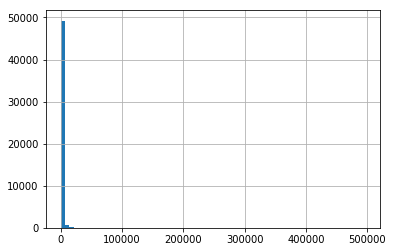

In [9]:
#view every feature hist 
train_data['当月金融理财类应用使用总次数'].hist(bins=70)

## Age Group

In [10]:
def group_age(x):
    if x <= 18:
        return 1
    elif x <= 30:
        return 2
    elif x <= 35:
        return 3
    elif x <= 45:
        return 4
    else:
        return 5

#train_data['年龄段'] = train_data['用户年龄'].apply(group_age)
#local_test_data['年龄段'] = local_test_data['用户年龄'].apply(group_age)
#test_data['年龄段'] = test_data['用户年龄'].apply(group_age)

# Change to English

In [11]:
train_data.columns = ['uid','true_name_flag','age','uni_student_flag','blk_list_flag',\
                     '4g_unhealth_flag','net_age_till_now','latest_pay_till_now','latest_pay_amount',\
                     'recent_6month_avg_cost','curr_month_cost','curr_month_balance',\
                     'curr_overdue_flag','cost_sensitivity','connect_people_num','freq_shopping_flag',\
                     'recent_3month_shopping_count','wanda_flag','sam_flag','movie_flag',\
                     'tour_flag','sport_flag','online_shopping_count','express_count',\
                     'finance_app_count','video_app_count','flight_count','train_count',\
                     'tour_app_count','score']

local_test_data.columns = train_data.columns
test_data.columns = train_data.columns[:-1]

# Add Features

In [12]:
def add_feature(df):
    df['curr_pay_cover_cost'] = df['latest_pay_amount'] - df['curr_month_cost']
    
    #df['modern_mall'] = 0
    #df['modern_mall'][(df['wanda_flag']+df['sam_flag'])>=1] = 1
    #df['traffic_count'] = df['flight_count'] + df['train_count']

    # 缴费方式
    df['pay_way'] = 0
    df['pay_way'][(df['latest_pay_amount'] % 10 == 0) & df['latest_pay_amount'] != 0] = 1

    # 消费稳定性
    df['last_pay_compare_6month_avg'] = df['latest_pay_amount']/(df['recent_6month_avg_cost']+1)
    df['curr_month_cost_compare_6month_avg'] = df['curr_month_cost']/(df['recent_6month_avg_cost']+1)
    
    #余额/话费, 余额/平均话费
    df['prepare_next_month_compare_curr'] = df['curr_month_balance'] / (df['curr_month_cost'] + 1)
    df['prepare_next_month_compare_6month_avg'] = df['curr_month_balance'] / (df['recent_6month_avg_cost'] + 1)
    return df

train_data = add_feature(train_data)
local_test_data = add_feature(local_test_data)
test_data = add_feature(test_data)

## Long Tail Log

In [13]:
def log_feature(df):
    user_bill_features = ['latest_pay_till_now', 'recent_6month_avg_cost',
                              'curr_month_cost', 'curr_month_balance']
    log_features = ['online_shopping_count', 'express_count', 'finance_app_count', 
                    'video_app_count','flight_count','train_count', 
                    'tour_app_count']
    for col in user_bill_features + log_features:
        df[col] = df[col].map(lambda x: np.log1p(x))
    return df

train_data = log_feature(train_data)
local_test_data = log_feature(local_test_data)
test_data = log_feature(test_data)

In [14]:
corr_matrix = train_data.corr()

In [15]:
corr = corr_matrix.abs().unstack().sort_values(ascending=False, kind="quicksort").reset_index()
#unstack n*n -> n^2*1
corr = corr[corr['level_0'] < corr['level_1']]

In [16]:
corr.head(30)

,level_0,level_1,0
36,prepare_next_month_compare_6month_avg,prepare_next_month_compare_curr,0.981312
38,curr_month_cost,recent_6month_avg_cost,0.925441
39,finance_app_count,online_shopping_count,0.788121
41,online_shopping_count,video_app_count,0.754171
44,finance_app_count,video_app_count,0.662225
45,curr_pay_cover_cost,last_pay_compare_6month_avg,0.612923
47,last_pay_compare_6month_avg,latest_pay_amount,0.595815
49,recent_6month_avg_cost,score,0.553747
52,latest_pay_amount,latest_pay_till_now,0.550798
53,net_age_till_now,score,0.546893


In [17]:
corr.tail(30)

,level_0,level_1,0
1166,prepare_next_month_compare_6month_avg,true_name_flag,0.002338
1168,prepare_next_month_compare_6month_avg,wanda_flag,0.002313
1170,express_count,last_pay_compare_6month_avg,0.002276
1172,age,uni_student_flag,0.002206
1173,prepare_next_month_compare_6month_avg,uni_student_flag,0.002086
1176,prepare_next_month_compare_curr,uni_student_flag,0.002072
1178,4g_unhealth_flag,wanda_flag,0.001971
1180,prepare_next_month_compare_curr,true_name_flag,0.001944
1181,sam_flag,uni_student_flag,0.001933
1183,prepare_next_month_compare_curr,train_count,0.001900


In [18]:
nfolds = 5
SEED = 2019

train_label = train_data['score']
local_test_label = local_test_data['score']

folds = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=SEED)

In [19]:
X_train = train_data.drop(['uid','score','blk_list_flag'], axis=1)
X_local_test = local_test_data.drop(['uid','score','blk_list_flag'], axis=1)
X_test = test_data.drop(['uid','blk_list_flag'], axis=1)
y = train_label

In [24]:
def train_model(X_train, X_local_test, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(X_train.shape[0])
    local_test = np.zeros(X_local_test.shape[0])
    cv_pred = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    splits = folds.split(X_train, y)

    for i, (train_idx, valid_idx) in enumerate(splits):
        
        print('Fold', i, 'started at', time.ctime())
        X_train_fold_old, X_valid_fold = X_train.iloc[train_idx, :], X_train.iloc[valid_idx, :]
        y_train_fold_old, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]
        
        #no oversampling
        #X_train_fold,y_train_fold = SMOTE(random_state=1997, ratio=0.5).fit_resample(X_train_fold_old, y_train_fold_old.ravel())
        X_train_fold,y_train_fold = X_train_fold_old, y_train_fold_old
        print("After OverSampling, counts of label '1': {}".format(sum(y_train_fold==1)))
        print("After OverSampling, counts of label '0': {}".format(sum(y_train_fold==0)))
        
        if model_type == 'lgb':
            dtrain = lgb.Dataset(X_train_fold, label=y_train_fold)
            dvalid = lgb.Dataset(X_valid_fold, label=y_valid_fold)
            
            model = lgb.train(params,
                    dtrain,
                    num_boost_round=10000,
                    valid_sets = [dtrain, dvalid],
                    verbose_eval=500,
                    early_stopping_rounds=50)
            
            y_pred_valid_fold = model.predict(X_valid_fold)
            if(X_local_test.shape[0]!=0):
                y_local_pred = model.predict(X_local_test, num_iteration=model.best_iteration)
            else:
                y_local_pred = np.zeros(X_local_test.shape[0])
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            dtrain = xgb.DMatrix(data=X_train_fold, label=y_train_fold, feature_names=X_train.columns)
            dvalid = xgb.DMatrix(data=X_valid_fold, label=y_valid_fold, feature_names=X_train.columns)

            watchlist = [(dtrain, 'train'), (dvalid, 'valid_data')]
            model = xgb.train(dtrain=dtrain, num_boost_round=10000, 
                              evals=watchlist, early_stopping_rounds=50, verbose_eval=500, 
                              params=params)
            y_pred_valid_fold = model.predict(xgb.DMatrix(X_valid_fold, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            if(X_local_test.shape[0]!=0):
                y_local_pred = model.predict(xgb.DMatrix(X_local_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            else:
                y_local_pred = np.zeros(X_local_test.shape[0])
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
            
        if model_type == 'cat':
            model = CatBoostRegressor(early_stopping_rounds=50, **params)
            model.fit(X_train_fold, y_train_fold, 
                      eval_set=(X_valid_fold, y_valid_fold), cat_features=[], 
                      verbose=500)

            y_pred_valid_fold = model.predict(X_valid_fold)
            if(X_local_test.shape[0]!=0):
                y_local_pred = model.predict(X_local_test)
            else:
                y_local_pred = np.zeros(X_local_test.shape[0])
            y_pred = model.predict(X_test)
            
            
        oof[valid_idx] = y_pred_valid_fold.reshape(-1,)
        scores.append(mean_absolute_error(y_valid_fold, y_pred_valid_fold))
        print("Fold " + str(i) + " mean_absolute_error: ", mean_absolute_error(y_valid_fold, y_pred_valid_fold))

        if averaging == 'usual':
            local_test += y_local_pred
            cv_pred += y_pred
        elif averaging == 'rank':
            local_test += pd.Series(y_local_pred).rank().values
            cv_pred += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X_train.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = i + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
            
        if model_type == 'xgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X_train.columns
            fold_importance["importance"] = model.get_score().values()
            fold_importance["fold"] = i + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
            
        if model_type == 'cat':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X_train.columns
            fold_importance["importance"] = model.get_feature_importance()
            fold_importance["fold"] = i + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    local_test /= nfolds
    cv_pred /= nfolds
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    
    feature_importance["importance"] /= nfolds
    if plot_feature_importance:
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:50].index

        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
        plt.title('Features (avg over folds)');

        #return oof, prediction, feature_importance
    return oof, local_test, cv_pred, scores

/home/jionie/py3env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



Fold 0 started at Sun Mar 17 19:27:55 2019
After OverSampling, counts of label '1': 0
After OverSampling, counts of label '0': 0
Training until validation scores don't improve for 50 rounds.
[500]	training's l2: 355.897	valid_1's l2: 381.894
[1000]	training's l2: 334.393	valid_1's l2: 372.11
[1500]	training's l2: 321.913	valid_1's l2: 369.831
[2000]	training's l2: 312.095	valid_1's l2: 369.011
[2500]	training's l2: 302.743	valid_1's l2: 368.545
Early stopping, best iteration is:
[2477]	training's l2: 303.051	valid_1's l2: 368.477
Fold 0 mean_absolute_error:  14.758802506495677
Fold 1 started at Sun Mar 17 19:28:00 2019
After OverSampling, counts of label '1': 0
After OverSampling, counts of label '0': 0
Training until validation scores don't improve for 50 rounds.
[500]	training's l2: 355.755	valid_1's l2: 378.909
[1000]	training's l2: 335.046	valid_1's l2: 369.845
[1500]	training's l2: 322.535	valid_1's l2: 367.835
[2000]	training's l2: 312.032	valid_1's l2: 367.028
Early stopping, be

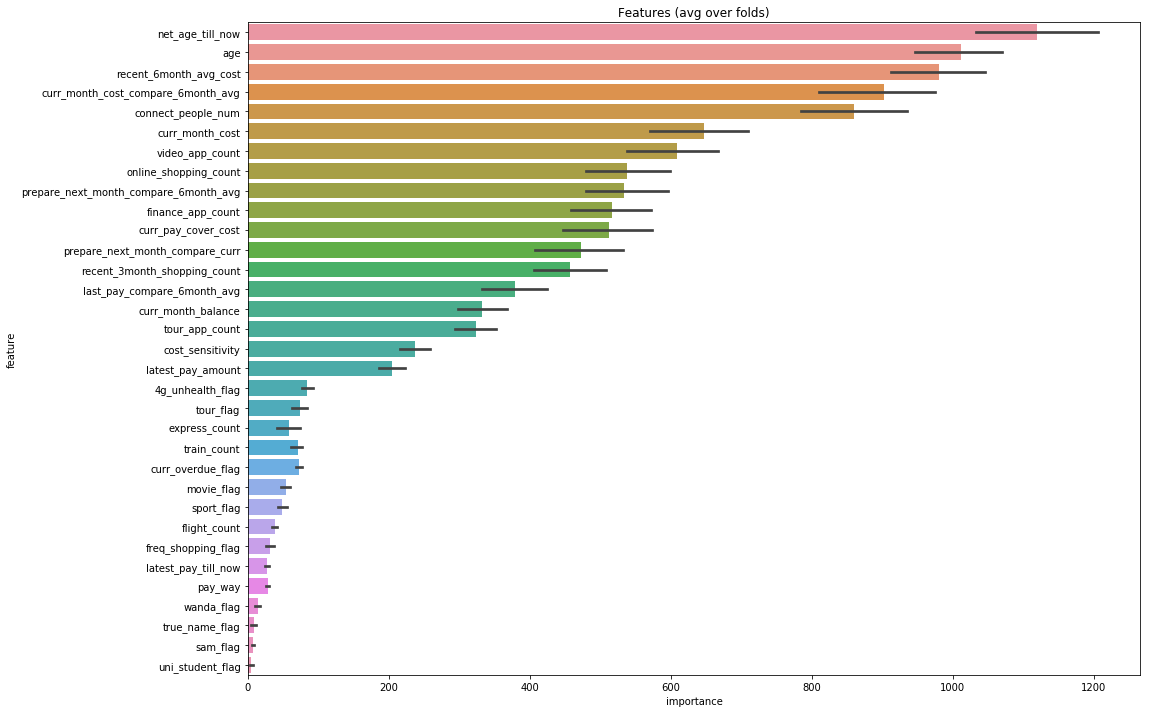

In [26]:
#para
params_mse_lgb = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'feature_fraction': 0.66,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'num_leaves': 31,
    'verbose': -1,
    'max_depth': 5,
    'lambda_l2': 5, 'lambda_l1': 0, 'nthread': 8,
    'seed': 89
}

oof_lgb_mse, local_test_lgb_mse, cv_pred_lgb_mse, scores_lgb_mse = train_model(X_train, X_local_test, X_test, train_label, params=params_mse_lgb, folds=folds, model_type='lgb', plot_feature_importance=True)

print("oof_lgb_mse score: ", 1/(1+mean_absolute_error(oof_lgb_mse, train_label)))

/home/jionie/py3env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



Fold 0 started at Sun Mar 17 19:31:35 2019
After OverSampling, counts of label '1': 0
After OverSampling, counts of label '0': 0
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 14.5714	valid_1's l1: 15.045
[1000]	training's l1: 14.1436	valid_1's l1: 14.8463
[1500]	training's l1: 13.8835	valid_1's l1: 14.7933
Early stopping, best iteration is:
[1743]	training's l1: 13.7789	valid_1's l1: 14.7802
Fold 0 mean_absolute_error:  14.780211006877563
Fold 1 started at Sun Mar 17 19:31:39 2019
After OverSampling, counts of label '1': 0
After OverSampling, counts of label '0': 0
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 14.5516	valid_1's l1: 15.0127
[1000]	training's l1: 14.1399	valid_1's l1: 14.8257
[1500]	training's l1: 13.8807	valid_1's l1: 14.7811
[2000]	training's l1: 13.6578	valid_1's l1: 14.7586
[2500]	training's l1: 13.4625	valid_1's l1: 14.7442
Early stopping, best iteration is:
[2671]	training's l1: 13.399	valid_

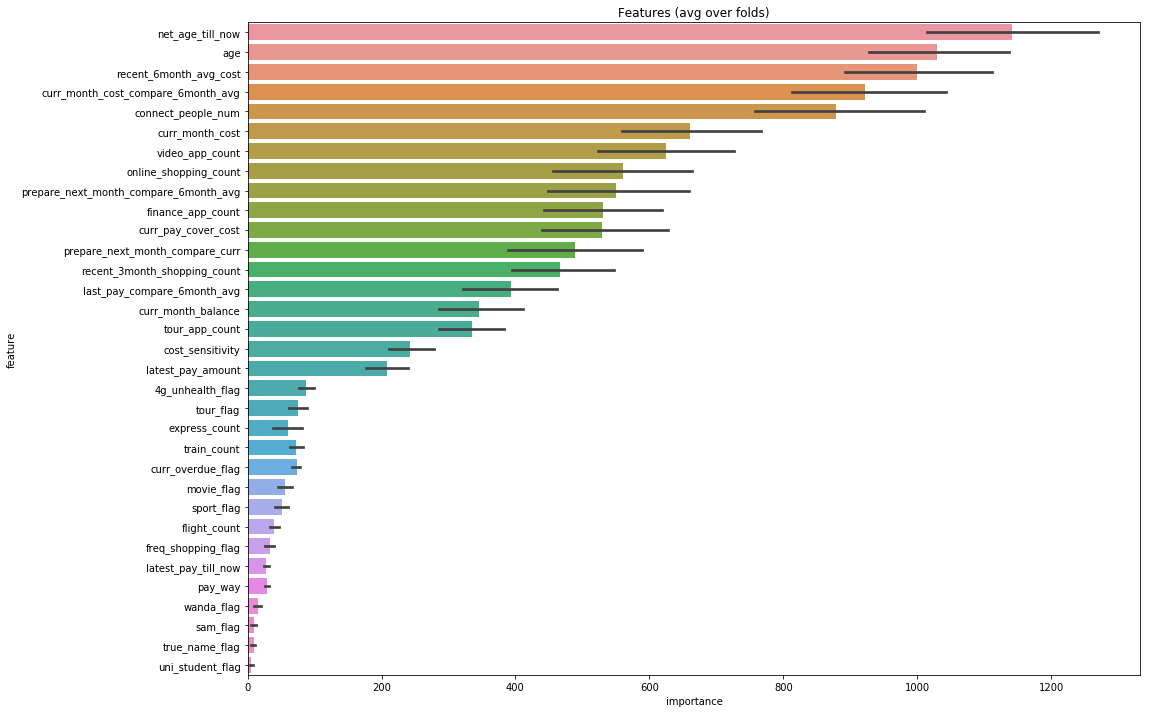

In [27]:
#para
params_mae_lgb = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mae',
    'feature_fraction': 0.66,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'num_leaves': 31,
    'verbose': -1,
    'max_depth': 5,
    'lambda_l2': 5, 'lambda_l1': 0, 'nthread': 8,
    'seed': 89
}

oof_lgb_mae, local_test_lgb_mae, cv_pred_lgb_mae, scores_lgb_mae = train_model(X_train, X_local_test, X_test, train_label, params=params_mae_lgb, folds=folds, model_type='lgb', plot_feature_importance=True)

print("oof_lgb_mae score: ", 1/(1+mean_absolute_error(oof_lgb_mae, train_label)))

/home/jionie/py3env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



Fold 0 started at Sun Mar 17 19:41:51 2019
After OverSampling, counts of label '1': 0
After OverSampling, counts of label '0': 0
[0]	train-mae:611.436	valid_data-mae:611.16
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 50 rounds.
[500]	train-mae:15.0586	valid_data-mae:15.5532
[1000]	train-mae:14.0414	valid_data-mae:14.84
[1500]	train-mae:13.7396	valid_data-mae:14.7882
[2000]	train-mae:13.4794	valid_data-mae:14.7671
Stopping. Best iteration:
[2074]	train-mae:13.4422	valid_data-mae:14.7653

Fold 0 mean_absolute_error:  14.765345
Fold 1 started at Sun Mar 17 19:42:12 2019
After OverSampling, counts of label '1': 0
After OverSampling, counts of label '0': 0
[0]	train-mae:611.367	valid_data-mae:611.42
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 50 rounds.
[500]	train-mae:15.0502	valid_data-mae:15.498

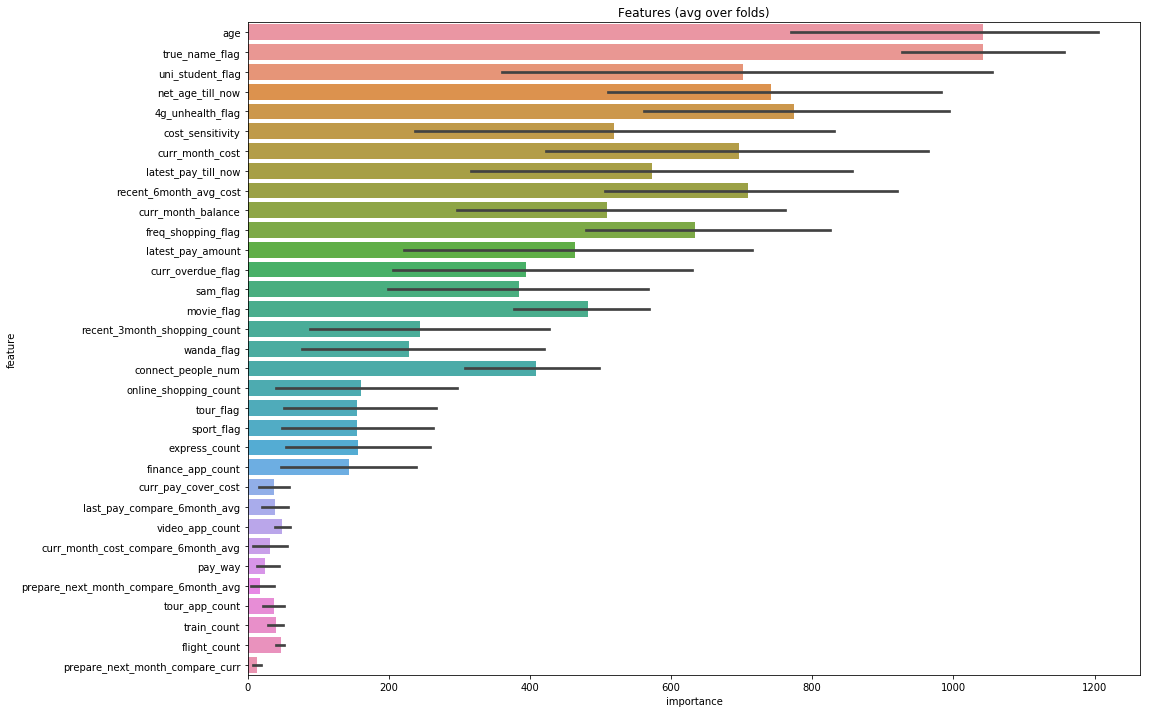

In [28]:
def fair_obj(preds, dtrain):
    fair_constant = 2
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

params_mae_xgb = {
        'booster': 'gbtree',
        'learning_rate': 0.01,
        'max_depth': 5,
        'subsample': 0.66,
        'colsample_bytree': 0.8,
        'obj': fair_obj,
        'eval_metric': 'mae',
        'n_estimators': 10000,
        'min_child_weight': 3,
        'gamma': 0,
        'silent': True,
        'n_jobs': -1,
        'random_state': 2019,
        'reg_alpha': 2,
        'reg_lambda': 0.1,
        'alpha': 1,
        'verbose': 1
    }

oof_xgb_mae, local_test_xgb_mae, cv_pred_xgb_mae, scores_xgb_mae = train_model(X_train, X_local_test, X_test, train_label, params=params_mae_xgb, folds=folds, model_type='xgb', plot_feature_importance=True)
print("oof_xgb_mae score: ", 1/(1+mean_absolute_error(oof_xgb_mae, train_label)))

Fold 0 started at Sun Mar 17 19:44:18 2019
After OverSampling, counts of label '1': 0
After OverSampling, counts of label '0': 0
[0]	train-rmse:612.881	valid_data-rmse:612.632
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 50 rounds.


/home/jionie/py3env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



[500]	train-rmse:19.1392	valid_data-rmse:19.9019
[1000]	train-rmse:18.0741	valid_data-rmse:19.2828
[1500]	train-rmse:17.6635	valid_data-rmse:19.2294
Stopping. Best iteration:
[1897]	train-rmse:17.3817	valid_data-rmse:19.2106

Fold 0 mean_absolute_error:  14.769664
Fold 1 started at Sun Mar 17 19:44:38 2019
After OverSampling, counts of label '1': 0
After OverSampling, counts of label '0': 0
[0]	train-rmse:612.821	valid_data-rmse:612.864
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 50 rounds.
[500]	train-rmse:19.1445	valid_data-rmse:19.7839
[1000]	train-rmse:18.098	valid_data-rmse:19.2025
[1500]	train-rmse:17.6889	valid_data-rmse:19.1487
[2000]	train-rmse:17.3434	valid_data-rmse:19.128
Stopping. Best iteration:
[2054]	train-rmse:17.3073	valid_data-rmse:19.1258

Fold 1 mean_absolute_error:  14.745264
Fold 2 started at Sun Mar 17 19:44:59 2019
After OverSampling, counts of label '1': 0
After

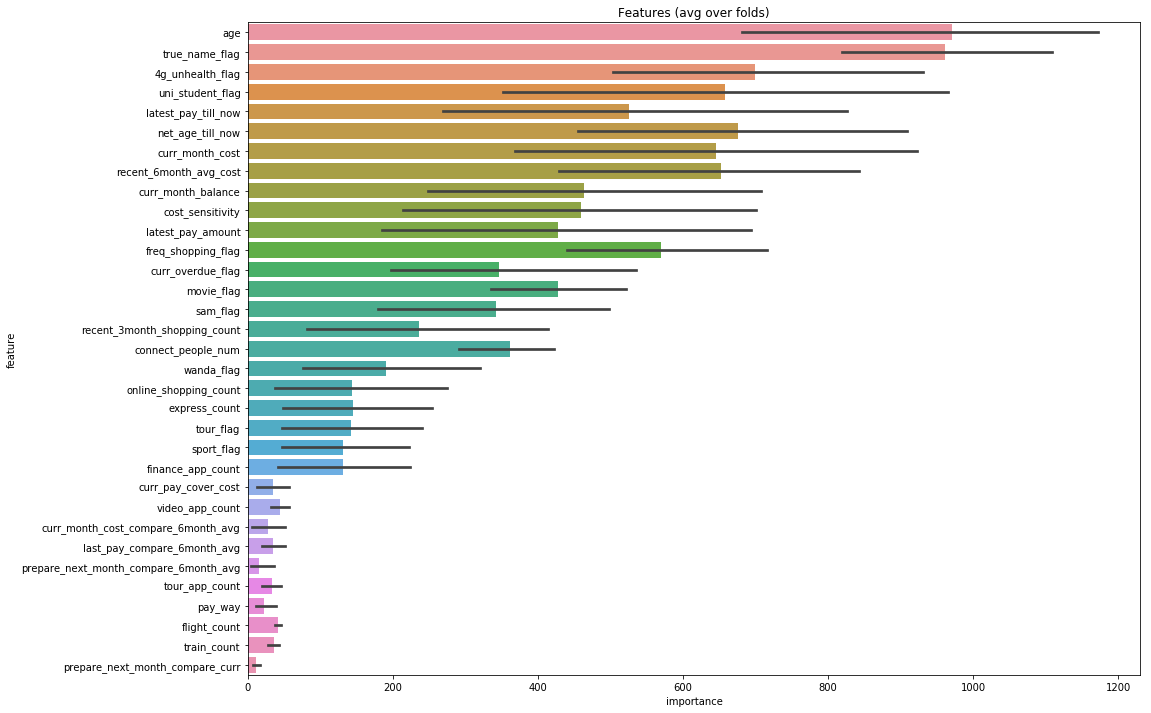

In [29]:
params_mse_xgb = {
        'booster': 'gbtree',
        'learning_rate': 0.01,
        'max_depth': 5,
        'subsample': 0.66,
        'colsample_bytree': 0.8,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'n_estimators': 10000,
        'min_child_weight': 3,
        'gamma': 0,
        'silent': True,
        'n_jobs': -1,
        'random_state': 2019,
        'reg_alpha': 2,
        'reg_lambda': 0.1,
        'alpha': 1,
        'verbose': 1
    }

oof_xgb_mse, local_test_xgb_mse, cv_pred_xgb_mse, scores_xgb_mse = train_model(X_train, X_local_test, X_test, train_label, params=params_mse_xgb, folds=folds, model_type='xgb', plot_feature_importance=True)
print("oof_xgb_mse score: ", 1/(1+mean_absolute_error(oof_xgb_mse, train_label)))

## Ensemble

In [30]:
sub_pred = (cv_pred_lgb_mse+cv_pred_lgb_mae+cv_pred_xgb_mse+cv_pred_xgb_mae)/4

In [31]:
print(sub_pred.shape)

(50000,)


In [32]:
sample_sub['score'] = sub_pred
sample_sub['score'] = sample_sub['score'].apply(lambda x: int(np.round(x)))
sample_sub[['id', 'score']].to_csv('submission.csv', index=False)